# Keras Time-Series Anomaly Detection


https://keras.io/examples/timeseries/timeseries_anomaly_detection/

https://www.kaggle.com/datasets/boltzmannbrain/nab?resource=download

In [56]:
# Importing required libraries 


import pandas as pd
import matplotlib.pyplot as plt
import  numpy as np 
import tensorflow.keras as keras
from tensorflow.keras import layers



In the Keras Time-Series Anomaly Detection example the user uses the *Numenta Anomaly Benchmark(NAB)* dataset. It provides artifical timeseries data containing labeled anomalous periods of behavior. Data are ordered, timestamped, single-valued metrics. 



In [57]:
# Root of URLs.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'



In [58]:
# 
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

print(df_small_noise.head())



                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120


In [59]:
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


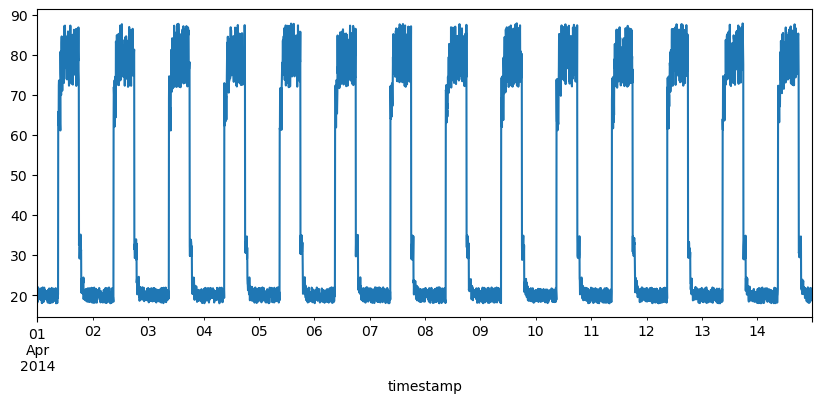

In [5]:
# 
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_small_noise.plot(legend=False, ax=ax);

In [6]:
#
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [7]:
print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


In [8]:

df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


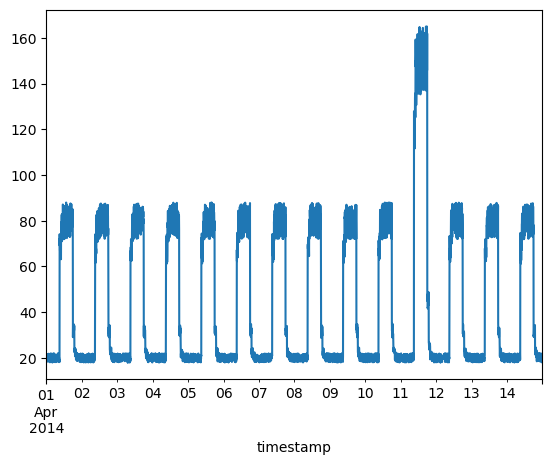

In [9]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

### Preparing training data 


In [10]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()



In [11]:
training_std = df_small_noise.std()

In [12]:
df_training_value = (df_small_noise - training_mean) / training_std
# 
df_training_value.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [13]:
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()

In [14]:
df_small_noise

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


In [15]:
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.438353335806646, -7.342627387941552e-14, -2.616541242931684e-15)

In [16]:
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

(28.077122281262515, 28.077122281262508, 1.0000000000000018)

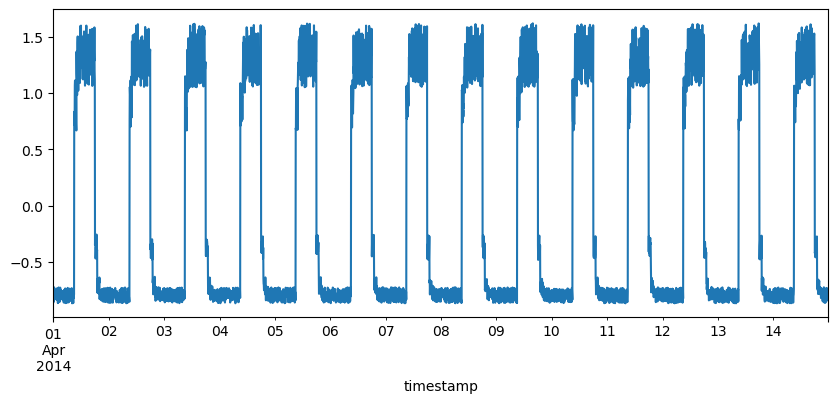

In [17]:
# 
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_training_value.plot(legend=False, ax=ax);

In [18]:
window_size = 288
#Window example:

#[1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
#window_size = 3
#[1, 1, 2]
#[1, 2, 4]
#[2, 4, 5]
#[4, 5, 6]



In [19]:
# Window list example.
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]

In [20]:
# Example window size.
win_size = 3

In [21]:
# Length of L.
len(L)
12

12

In [22]:
# Remove brackets.
len(L) - win_size + 1

# Print the windows.
for i in range(len(L) - win_size + 1):
    print(L[i:i + win_size])

[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
[5, 6, 7]
[6, 7, 1]
[7, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]


In [23]:
wins = []

# Generate the windows
for i in range(len(L) - win_size + 1):
    wins.append(L[i:i + win_size])


In [24]:
np.stack(wins)

array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

In [25]:
def windows(vals, N=window_size):
  # 
  L = []
  # 
  for i in range(len(vals) - N + 1):
    # 
    L.append(vals[i:i+N])
  # Stack
  return np.stack(L)

In [26]:
x_train = windows(df_training_value)
# 
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [27]:
#
df_training_value['value'].values

# 
x_train[0].flatten()

array([-0.85882857, -0.72899302, -0.84814772, -0.72958579, -0.731173  ,
       -0.75730984, -0.77645641, -0.7880838 , -0.747012  , -0.829166  ,
       -0.80377285, -0.7821597 , -0.81182078, -0.80949918, -0.82334701,
       -0.79001779, -0.74922405, -0.84169024, -0.73727717, -0.77223023,
       -0.75311352, -0.79116337, -0.75934728, -0.86809294, -0.75381057,
       -0.86468256, -0.74361965, -0.72908121, -0.82850668, -0.84043795,
       -0.76136364, -0.8343536 , -0.74708881, -0.85574949, -0.85245676,
       -0.73090636, -0.77440264, -0.74974936, -0.82419543, -0.77402585,
       -0.78574242, -0.7844733 , -0.77316412, -0.78843253, -0.80927467,
       -0.83109167, -0.76090519, -0.83816509, -0.77176485, -0.83715923,
       -0.78131343, -0.76396862, -0.83924191, -0.86186112, -0.85174179,
       -0.78406773, -0.74938477, -0.86399047, -0.76581026, -0.82177506,
       -0.80222751, -0.73807119, -0.82310669, -0.80410682, -0.86845167,
       -0.85877599, -0.83356075, -0.86643297, -0.78045221, -0.80

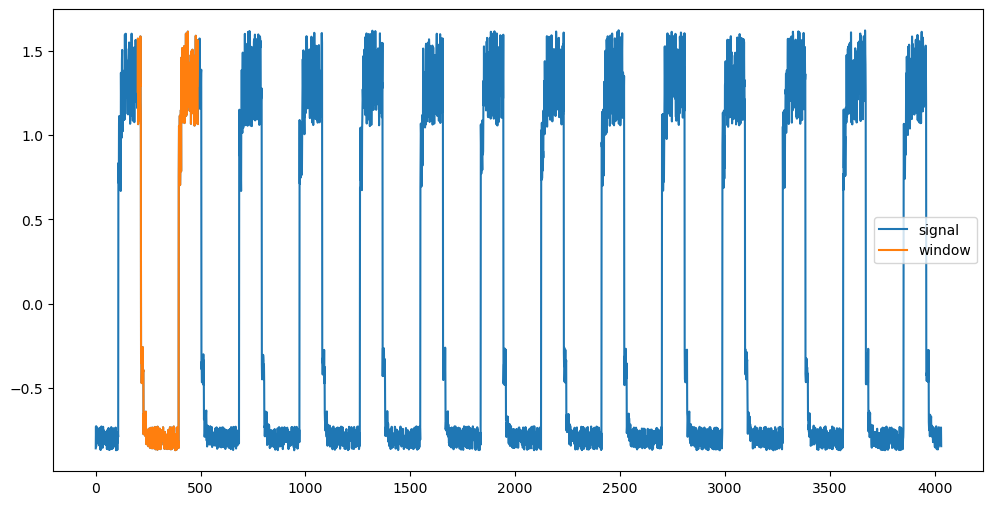

In [28]:
# 
window_no = 200

# 
fig, ax = plt.subplots(figsize=(12, 6))

# 
y = df_training_value['value'].values

# 
ax.plot(np.arange(y.shape[0]), y, label='signal')

# The first window.
w = x_train[window_no].flatten()

# 
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')

ax.legend();

In [29]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


In [30]:
#
layers = [
  #
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  #
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]


In [31]:
#
model = keras.Sequential(layers)


2023-01-03 23:29:27.781697: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-03 23:29:27.781829: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-03 23:29:27.781864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (penguin): /proc/driver/nvidia/version does not exist
2023-01-03 23:29:27.782220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
# 
optimizer = keras.optimizers.Adam(learning_rate=0.001)
# 


In [33]:
model.compile(optimizer=optimizer, loss="mse")


In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [35]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)



Epoch 1/50
27/27 [==============================] - 3s 79ms/step - loss: 0.4131 - val_loss: 0.0648
Epoch 2/50
27/27 [==============================] - 2s 66ms/step - loss: 0.0769 - val_loss: 0.0425
Epoch 3/50
27/27 [==============================] - 2s 67ms/step - loss: 0.0599 - val_loss: 0.0377
Epoch 4/50
27/27 [==============================] - 2s 69ms/step - loss: 0.0510 - val_loss: 0.0316
Epoch 5/50
27/27 [==============================] - 2s 62ms/step - loss: 0.0430 - val_loss: 0.0285
Epoch 6/50
27/27 [==============================] - 2s 67ms/step - loss: 0.0381 - val_loss: 0.0269
Epoch 7/50
27/27 [==============================] - 2s 66ms/step - loss: 0.0345 - val_loss: 0.0258
Epoch 8/50
27/27 [==============================] - 2s 65ms/step - loss: 0.0317 - val_loss: 0.0260
Epoch 9/50
27/27 [==============================] - 2s 67ms/step - loss: 0.0293 - val_loss: 0.0249
Epoch 10/50
27/27 [==============================] - 2s 61ms/step - loss: 0.0274 - val_loss: 0.0278
Epoch 11/

In [36]:
history.history["loss"]

[0.41306325793266296,
 0.0769125446677208,
 0.05987933278083801,
 0.050954073667526245,
 0.04302437976002693,
 0.038080960512161255,
 0.034471530467271805,
 0.03171953186392784,
 0.029335329309105873,
 0.027392592281103134,
 0.02590939961373806,
 0.02463267743587494,
 0.023554937914013863,
 0.022672582417726517]

In [37]:
history.history["val_loss"]

[0.06477567553520203,
 0.042453017085790634,
 0.03773975744843483,
 0.03158191964030266,
 0.028474826365709305,
 0.02690024860203266,
 0.025775518268346786,
 0.02599514275789261,
 0.02491886354982853,
 0.027800098061561584,
 0.027724454179406166,
 0.028062397614121437,
 0.028435999527573586,
 0.027963249012827873]

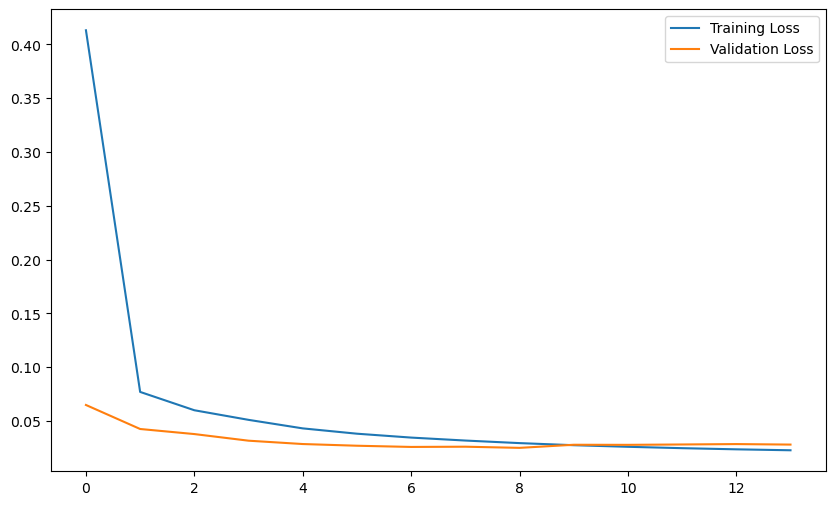

In [38]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.plot(history.history["loss"], label="Training Loss")
# 
ax.plot(history.history["val_loss"], label="Validation Loss")
# 
ax.legend();

Anomaly detection 

In [39]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)






118/118 [==============================] - 1s 10ms/step


In [40]:
# Calculate loss...
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)


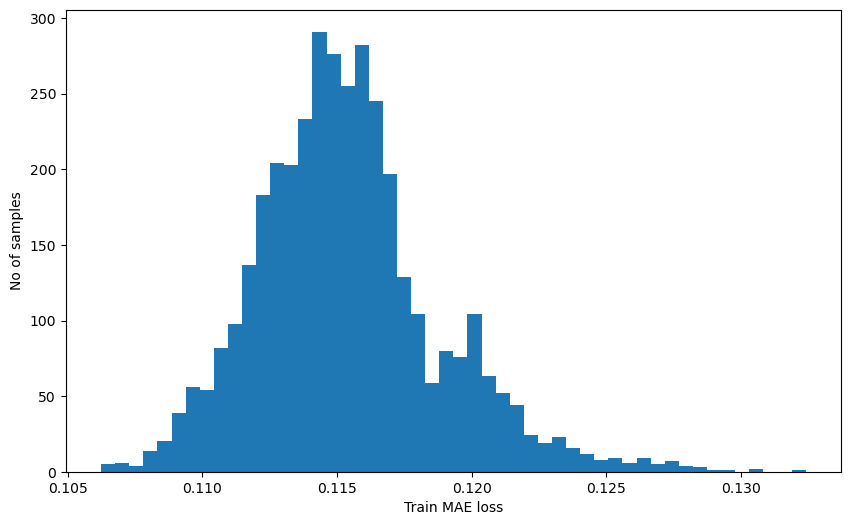

In [41]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.hist(train_mae_loss, bins=50)
# 
ax.set_xlabel("Train MAE loss")
#
ax.set_ylabel("No of samples");

In [42]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)


Reconstruction error threshold:  0.13240770330311863


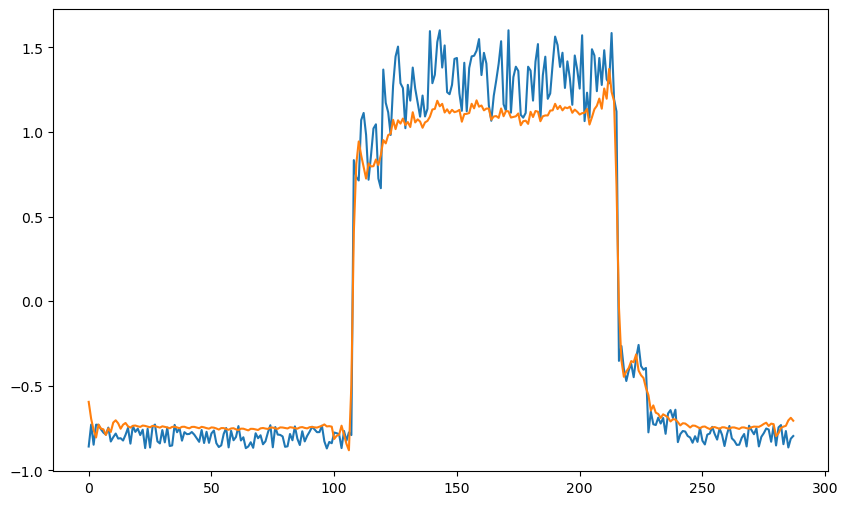

In [43]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
ax.plot(x_train[0])

# 
ax.plot(x_train_pred[0]);


prepare test data


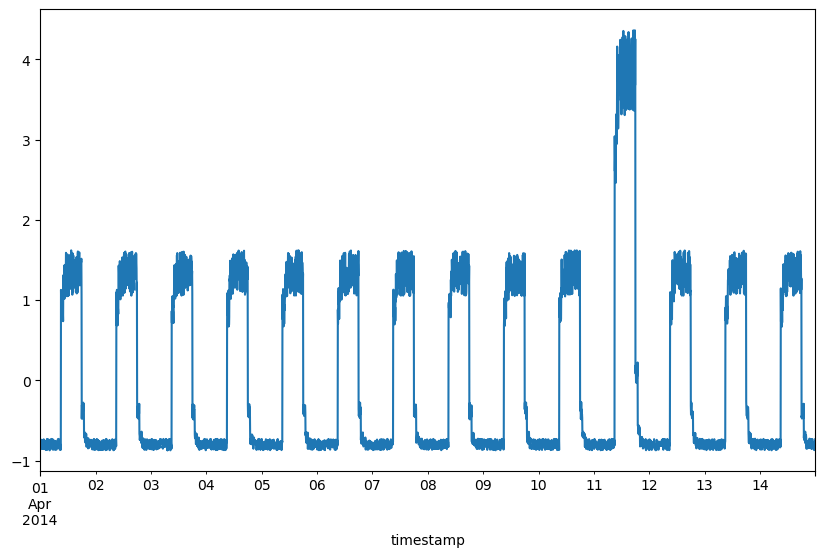

In [46]:
# 
df_test_value = (df_daily_jumpsup - training_mean) / training_std
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_test_value.plot(legend=False, ax=ax);


In [47]:
# Create sequences from test values.
x_test = windows(df_test_value.values)

x_test.shape
(3745, 288, 1)






(3745, 288, 1)

In [48]:
# 
x_test_pred = model.predict(x_test)



118/118 [==============================] - 1s 10ms/step


In [49]:
# 
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

test_mae_loss




array([[0.11502521],
       [0.11400172],
       [0.11448198],
       ...,
       [0.1136481 ],
       [0.1137131 ],
       [0.11352203]])

In [50]:
# 
test_mae_loss = test_mae_loss.reshape((-1))

test_mae_loss

array([0.11502521, 0.11400172, 0.11448198, ..., 0.1136481 , 0.1137131 ,
       0.11352203])

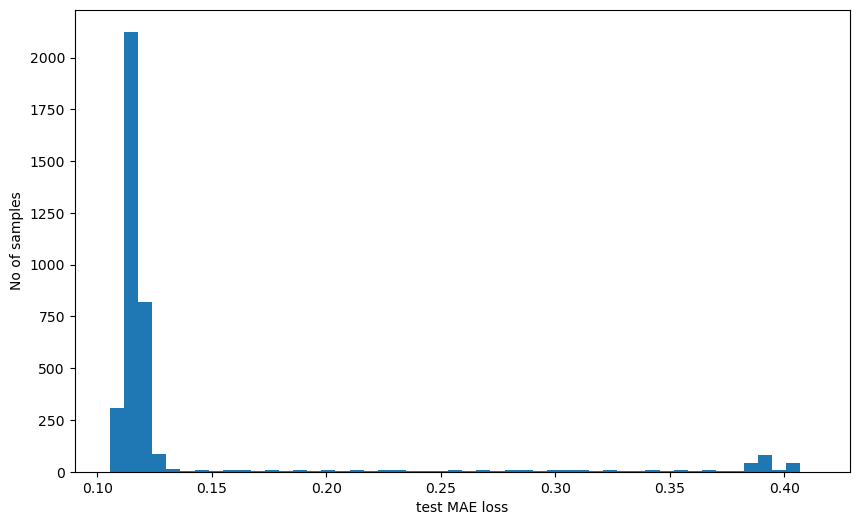

In [51]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

#
ax.hist(test_mae_loss, bins=50)

# 
ax.set_xlabel("test MAE loss")

# 
ax.set_ylabel("No of samples");

In [52]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# NUmber of anomalies.
np.sum(anomalies)

396

In [53]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [54]:
# 
df_subset = df_daily_jumpsup.iloc[inds]


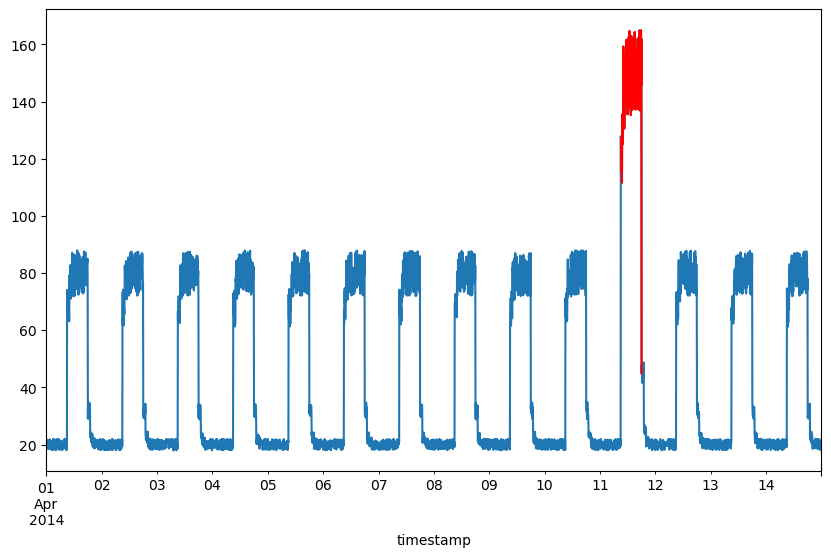

In [55]:
#
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_daily_jumpsup.plot(legend=False, ax=ax)

# 
df_subset.plot(legend=False, ax=ax, color="r");